# Project: Wrangling and Analyze Data

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import functools as ft
import requests
import json
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as cm
%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_archive = pd.read_csv('twitter_archive_enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

response.status_code

200

In [4]:
# Save the file
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
# Read TSV file
df_image = pd.read_csv('image_predictions.tsv', sep = '\t')

df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
## Download file using Requests library via URL provided 
#url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
#response = requests.get(url)
#
## Save the file
#with open('tweet-json.txt', mode = 'wb') as file:
#    file.write(response.content)

In [10]:
consumer_key = 'OSygnMbUjPF6cZqP0XUd4Yhzk'
consumer_secret = 'lUw2po6Z7z1txdYmTv4F8IloW8D62cShuHmltarE9Ch8fzLjir'
access_token = '2151495307-hgipt5U6PgCiLBxYnbaTdT8TUo7Ngs2LaD7w72h'
access_secret = 'JcrCtRqfNJJnIjoGG5x4CmM1Yn3aWeyRzsVNVuvgL0Zpn'

In [11]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [12]:
tweet_ids = df_archive.tweet_id.values
len(tweet_ids)

2356

In [13]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Fail
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293: 8

Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success
550: 805207613751304193
Success


Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807: 772102971039580160
Success
808

Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
1062: 741303864243200000
Success
1063: 741099773336379392
Success
10

Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
1311: 707038192327901184
Success
1312: 707021089608753152
Success
1313: 707014260413456384
Success
13

Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
1560: 688547210804498433
Success
1561: 688519176466644993
Success
1562: 688385280030670848
Success
1563: 688211956440801280
Success
15

Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
18

Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
2062: 671166507850801152
Success
20

Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
2311: 666786068205871104
Success
23

In [5]:
#Read downloaded txt file line by line into a pandas DataFrame
df_list = []
with open('tweet_json.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        parsed_json = json.loads(line)
        df_list.append({'tweet_id': parsed_json['id'],
                        'retweet_count': parsed_json['retweet_count'],
                        'favorite_count': parsed_json['favorite_count']})
        
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

df_tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6890,32957
1,892177421306343426,5193,28501
2,891815181378084864,3426,21430
3,891689557279858688,7102,35962
4,891327558926688256,7620,34381


## Assessing Data



### `df_archive`

In [6]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [8]:
for i in df_archive.columns:
    print(i, sum(df_archive[str(i)].isnull()))


tweet_id 0
in_reply_to_status_id 2278
in_reply_to_user_id 2278
timestamp 0
source 0
text 0
retweeted_status_id 2175
retweeted_status_user_id 2175
retweeted_status_timestamp 2175
expanded_urls 59
rating_numerator 0
rating_denominator 0
name 0
doggo 0
floofer 0
pupper 0
puppo 0


In [9]:
df_archive.duplicated().sum()

0

In [10]:
for i in df_archive.columns:
    print(i, sum(df_archive[str(i)].duplicated()))  

tweet_id 0
in_reply_to_status_id 2278
in_reply_to_user_id 2324
timestamp 0
source 2352
text 0
retweeted_status_id 2174
retweeted_status_user_id 2330
retweeted_status_timestamp 2174
expanded_urls 137
rating_numerator 2316
rating_denominator 2338
name 1399
doggo 2354
floofer 2354
pupper 2354
puppo 2354


In [11]:
df_archive[df_archive['tweet_id'].duplicated()].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

In [12]:
l_columns = ['rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo']
for i in l_columns:
    print(df_archive[str(i)].value_counts())
    print('\n')

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64


10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64


None     2259
doggo      97
Name: doggo, dtype: int64


None       2346
floofer      10
Name: floofer, dtype: int64


None      2099
pupper     257
Name: pupper, dtype: int64


None     2326
puppo      30
Name: puppo, dtype:

### `df_image`

In [13]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [15]:
for i in df_image.columns:
    print(i, sum(df_image[str(i)].isnull()))


tweet_id 0
jpg_url 0
img_num 0
p1 0
p1_conf 0
p1_dog 0
p2 0
p2_conf 0
p2_dog 0
p3 0
p3_conf 0
p3_dog 0


In [16]:
df_image.duplicated().sum()

0

In [17]:
for i in df_image.columns:
    print(i, sum(df_image[str(i)].duplicated()))  

tweet_id 0
jpg_url 66
img_num 2071
p1 1697
p1_conf 69
p1_dog 2073
p2 1670
p2_conf 71
p2_dog 2073
p3 1667
p3_conf 69
p3_dog 2073


In [18]:
df_image[df_image['tweet_id'].duplicated()].count()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [19]:
df_image[df_image['jpg_url'].duplicated()].count()

tweet_id    66
jpg_url     66
img_num     66
p1          66
p1_conf     66
p1_dog      66
p2          66
p2_conf     66
p2_dog      66
p3          66
p3_conf     66
p3_dog      66
dtype: int64

In [20]:
l_columns = ['img_num', 'p1', 'p2', 'p3']
for i in l_columns:
    print(df_image[str(i)].value_counts())
    print('\n')

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64


golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
web_site                      19
Cardigan                      19
beagle                        18
Maltese_dog                   18
teddy                         18
Eskimo_dog                    18
Shetland_sheepdog             18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
Italia

In [21]:
df_image.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

In [22]:
df_image['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [23]:
df_image['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [24]:
df_image['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [25]:
df_image.query('p1_dog== True and p2_dog==True and p3_dog== True')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
11,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,Gordon_setter,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True
12,666073100786774016,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg,1,Walker_hound,0.260857,True,English_foxhound,0.175382,True,Ibizan_hound,0.097471,True


In [26]:
df_image.query('p1_dog== True and p2_dog==True and p3_dog== True')['tweet_id'].nunique()

1243

### `df_tweet`

In [27]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 3 columns):
tweet_id          2325 non-null int64
retweet_count     2325 non-null int64
favorite_count    2325 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


In [28]:
df_tweet.describe()

,tweet_id,retweet_count,favorite_count
count,2.325000e+03,2325.000000,2325.000000
mean,7.416926e+17,2430.405161,6887.562581
std,6.814903e+16,4113.194963,10698.346882
min,6.660209e+17,0.000000,0.000000
25%,6.780233e+17,489.000000,1197.000000
50%,7.177900e+17,1130.000000,2989.000000
75%,7.986285e+17,2811.000000,8413.000000
max,8.924206e+17,69512.000000,142022.000000


In [29]:
for i in df_tweet.columns:
    print(i, sum(df_tweet[str(i)].isnull()))


tweet_id 0
retweet_count 0
favorite_count 0


In [30]:
df_tweet.duplicated().sum()

0

In [31]:
for i in df_tweet.columns:
    print(i, sum(df_tweet[str(i)].duplicated()))  

tweet_id 0
retweet_count 690
favorite_count 341


In [32]:
df_tweet[df_tweet['tweet_id'].duplicated()].count()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

### Quality issues

#### The four main data quality dimensions are:

- Completeness: missing data?
- Validity: does the data make sense?
- Accuracy: inaccurate data? (wrong data can still show up as valid)
- Consistency: standardization?

#### `df_archive` table

- Completeness:
    - Missing data in columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, because original tweets are not isolated from retweets.
    - Remove columns not needed for analysis: `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`.
    - Create a `rating` column, which contains the results of the `rating_numerator` divided by `rating_denominator`.
    - Split `timestamp` column into `date` and `time` columns and remove the `timestamp` column.
<br><br>
- Validity: 
    - 'None' values in `name`, should be 'NaN'.
    - 'None' values in `dog stage columns`, should be 'NaN'.
    - There are invalid `name` data: 'a' or 'an'.
    - Some records have more than one dog stage. 
<br><br> 
- Accuracy: 
   - Erroneous datatypes:
        - `tweet_id` datatype is int, shold be str.
        - `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` data types are float, should all be str.
        - `retweeted_status_timestamp`, `timestamp` should be datetime instead of str. 
   - Abnormal values in both `rating_numerator` and `rating_denominator`.
<br><br>
- Consistency: 
    - `rating_denominator` should be a standard 10.
    - The `source` column still has the HTML tags

#### `df_image` table

- Completeness: 
    - There are `jpg_url` duplications.
    - Unnecessary columns for dog breed predection (`p1`, `p2` and `p3`) i.e. could be packed into one column and get rid of the other three and any unneeded columns.
    - Unnecessary columns for prediction confidence (`p1_conf`, `p2_conf` and `p3_conf`) i.e. could be packed into one column and get rid of the other three and any unneeded columns.
<br><br>
- Accuracy: 
    - Some image predictions are not dog breeds.
    - Erroneous datatype for column `tweet_id`, should be str.
<br><br>
- Consistency: 
    - The dog breeds in the columns (`p1`, `p2` and `p3`) are not consistently lower or uppercase and an underscore is used instead of space.

#### `df_tweet` table

- Completeness: 
    - Few missing data.
<br><br>
- Accuracy:
    - Erroneous datatype for column `tweet_id`, should be str.

### Tidiness issues

#### Three requirements for tidiness:

- Each variable forms a column
- Each observation forms a row
- Each type of observational unit forms a table

1. Dog stage is in 4 columns (doggo, floofer, pupper, puppo), no need for that.

2. Merge `df_tweet` and `df_image` into  `df_archive`.

## Cleaning Data


In [33]:
# Make copies of original pieces of data
df_archive_copy = df_archive.copy()
df_image_copy = df_image.copy()
df_tweet_copy = df_tweet.copy()

### Issue #1:

#### Define:

Isolate original tweets from retweets (keep tweets with images).

#### Code

In [34]:
df_archive_copy= df_archive_copy[pd.isnull(df_archive_copy['retweeted_status_user_id'])]

#### Test

In [35]:
sum(df_archive_copy.retweeted_status_user_id.value_counts())

0

#### Code

In [36]:
df_archive_copy= df_archive_copy[df_archive_copy['expanded_urls'].notnull()]

#### Test

In [37]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: float64(4), int64(3), object(1

### Issue #2:

#### Define

Remove columns not needed for analysis: `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`.

#### Code

In [38]:
df_archive_copy.drop(['in_reply_to_status_id', 
                           'in_reply_to_user_id', 'source',
                           'retweeted_status_id', 
                           'retweeted_status_user_id', 
                           'retweeted_status_timestamp', 'expanded_urls'], 
                          axis=1, inplace=True)

#### Test

In [39]:
df_archive_copy.columns.values

array(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

### Issue #3:

#### Define

Extract the `rating` by taking the ratio of `numerator` and `denominator` after addressing the issue of decimal ratings

#### Code

In [40]:
df_archive_copy['rating'] = df_archive_copy.rating_numerator / df_archive_copy.rating_denominator

#### Test

In [41]:
df_archive_copy[['rating']].head()

,rating
0,1.3
1,1.3
2,1.2
3,1.3
4,1.2


### Issue #4:

#### Define

Split `timestamp` column into `date` and `time` columns and remove the `timestamp` column.

#### Code

In [42]:
#remove zeros from end of timestamp
df_archive_copy['timestamp'] = df_archive_copy['timestamp'].str[:-6]

#### Test

In [43]:
df_archive_copy['timestamp'].head()

0    2017-08-01 16:23:56
1    2017-08-01 00:17:27
2    2017-07-31 00:18:03
3    2017-07-30 15:58:51
4    2017-07-29 16:00:24
Name: timestamp, dtype: object

#### Code

In [44]:
#split timestamp column into date and time columns
df_archive_copy[['date', 'time']] = df_archive_copy['timestamp'].str.split(' ', 1, expand=True)

#### Test

In [45]:
df_archive_copy[['timestamp','date', 'time']].head()

,timestamp,date,time
0,2017-08-01 16:23:56,2017-08-01,16:23:56
1,2017-08-01 00:17:27,2017-08-01,00:17:27
2,2017-07-31 00:18:03,2017-07-31,00:18:03
3,2017-07-30 15:58:51,2017-07-30,15:58:51
4,2017-07-29 16:00:24,2017-07-29,16:00:24


#### Code

In [46]:
#drop timestamp column
df_archive_copy.drop(columns= 'timestamp', inplace= True)

#### Test

In [47]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2117 non-null int64
text                  2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
rating                2117 non-null float64
date                  2117 non-null object
time                  2117 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 215.0+ KB


### Issue #5:

#### Define

Craete `breed_prediction` column and assign the values of the columns (`p1`, `p2` and `p3`) to it.

#### Code

In [48]:
def breedPrediction(p):
    if p['p1_dog']:
        return(p['p1'])
    elif p['p2_dog']:
        return(p['p2'])
    elif p['p3_dog']:
        return(p['p3'])
    else:
        return(np.NaN)

    
df_image_copy['breed_prediction'] = df_image_copy.apply (lambda p: breedPrediction(p), axis=1)

#### Test

In [49]:
df_image_copy[['breed_prediction']].head()

,breed_prediction
0,Welsh_springer_spaniel
1,redbone
2,German_shepherd
3,Rhodesian_ridgeback
4,miniature_pinscher


### Issue #6:

#### Define

Craete column `prediction_confidence` and assign the values of the columns (`p1_conf`, `p2_conf` and `p3_conf`) to it.

#### Code

In [50]:
def predictionConfidence(pc):
    if pc['p1_dog']:
        return(pc['p1_conf'])
    elif pc['p2_dog']:
        return(pc['p2_conf'])
    elif pc['p3_dog']:
        return(pc['p3_conf'])
    else:
        return(np.NaN)
    
    
df_image_copy['prediction_confidence'] = df_image_copy.apply (lambda pc: predictionConfidence(pc), axis= 1)

#### Test

In [51]:
df_image_copy[['prediction_confidence']].head()

,prediction_confidence
0,0.465074
1,0.506826
2,0.596461
3,0.408143
4,0.560311


### Issue #7:

#### Define

Drop all columns that are not neccessary anymore.

#### Code

In [52]:
df_image_copy.drop(['img_num', 'p1', 'p2', 'p3', 'p1_conf', 'p2_conf', 'p3_conf', 'p1_dog', 'p2_dog', 'p3_dog'], axis= 1, inplace= True)

#### Test

In [53]:
df_image_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id                 2075 non-null int64
jpg_url                  2075 non-null object
breed_prediction         1751 non-null object
prediction_confidence    1751 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


### Issue #8:

#### Define
Merge `df_archive_copy`, `df_image_copy` and `df_tweet_copy` into one dataframe.

In [54]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2117 non-null int64
text                  2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
rating                2117 non-null float64
date                  2117 non-null object
time                  2117 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 215.0+ KB


In [55]:
df_image_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id                 2075 non-null int64
jpg_url                  2075 non-null object
breed_prediction         1751 non-null object
prediction_confidence    1751 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


In [56]:
df_tweet_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 3 columns):
tweet_id          2325 non-null int64
retweet_count     2325 non-null int64
favorite_count    2325 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


#### Code

In [57]:
datasets = [df_archive_copy, df_image_copy, df_tweet_copy]
df = ft.reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), datasets)

#### Test

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 17 columns):
tweet_id                 1986 non-null int64
text                     1986 non-null object
rating_numerator         1986 non-null int64
rating_denominator       1986 non-null int64
name                     1986 non-null object
doggo                    1986 non-null object
floofer                  1986 non-null object
pupper                   1986 non-null object
puppo                    1986 non-null object
rating                   1986 non-null float64
date                     1986 non-null object
time                     1986 non-null object
jpg_url                  1986 non-null object
breed_prediction         1678 non-null object
prediction_confidence    1678 non-null float64
retweet_count            1986 non-null int64
favorite_count           1986 non-null int64
dtypes: float64(2), int64(5), object(10)
memory usage: 279.3+ KB


In [59]:
#make a copy of df
df_copy = df.copy()

### Issue #9:

#### Define

Correct the erroneous datatype for the columns (`tweet_id`, `rating_numerator`, `rating_denominator`, `date` and `time`).

#### Code

In [60]:
df_copy['tweet_id'] = df_copy['tweet_id'].astype(str)
df_copy[['rating_numerator', 'rating_denominator']] = df_copy[['rating_numerator', 'rating_denominator']].astype(float)
df_copy['date'] =  pd.to_datetime(df_copy['date'])
df_copy['time'] = pd.to_datetime(df_copy['time'], format= '%H:%M:%S' ).dt.time

#### Test

In [61]:
print(df_copy['tweet_id'].dtypes)
print(df_copy['rating_numerator'].dtypes)
print(df_copy['rating_denominator'].dtypes)
print(df_copy['date'].dtypes)
print(df_copy['time'].dtypes)

object
float64
float64
datetime64[ns]
object


### Issue #10:

#### Define

Replace the values in column `name` which are registered as ("none") with NaN

#### Code

In [62]:
df_copy['name'].replace('None', np.nan, inplace = True)

#### Test

In [63]:
df_copy['name'].isnull().sum()

545

### Issue #11:

#### Define

Replace the wrongly registered names in the `name` column.

#### Code

In [64]:
# Extracting the lower case names, since they can't be a real names
lowercase_names = []
lowercase_names= df_copy[df_copy['name'].str[0].str.islower().fillna(False)]['name']

lowercase_names=list(lowercase_names)

df_copy['name'].replace(lowercase_names, np.nan, inplace = True)

df_copy['name'].replace('O', "O'Malley", inplace = True)

#### Test

In [65]:
df_copy['name'].isnull().sum()

643

In [66]:
df_copy['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', nan, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya', 'Mingus',
       'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl', 'Lola',
       'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty', 'Gus',
       'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford', 'Dewey',
       'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha', 'Lili',
       'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes',
       'B

### Issue #12:

#### Define

Drop the `jpg_url` duplications.

#### Code

In [67]:
df_copy.drop_duplicates(subset=['jpg_url'], keep='last', inplace= True)

#### Test

In [68]:
sum(df_copy['jpg_url'].duplicated())

0

### Issue #13:

#### Define

Change the `breed_prediction` underscores to spaces.

#### Code

In [69]:
for breed in ['breed_prediction']:
    df_copy[breed] = df_copy[breed].str.replace('_',' ')

#### Test

In [70]:
df_copy['breed_prediction']

0                               NaN
1                         Chihuahua
2                         Chihuahua
3                Labrador retriever
4                            basset
5          Chesapeake Bay retriever
6                       Appenzeller
7                        Pomeranian
8                     Irish terrier
9                          Pembroke
10                          Samoyed
11                   French bulldog
12                         Pembroke
13                   French bulldog
14                 golden retriever
15                          whippet
16                 golden retriever
17                 golden retriever
18                   Siberian husky
19                   French bulldog
20                           basset
21                              NaN
22                         Pembroke
23                 Mexican hairless
24                          Samoyed
25                        Chihuahua
26                           kuvasz
27                          

### Issue #14:

#### Define

Replace the values in column `dog_stages` which are registered as ("None") with NaN

#### Code

In [71]:
# handle none
df_copy.doggo.replace('None', '', inplace=True)
df_copy.floofer.replace('None', '', inplace=True)
df_copy.pupper.replace('None', '', inplace=True)
df_copy.puppo.replace('None', '', inplace=True)

# merge into column
df_copy['dog_stages'] = df_copy.doggo + df_copy.floofer + df_copy.pupper + df_copy.puppo

# handle multiple stages
df_copy.loc[df_copy.dog_stages == 'doggopupper', 'dog_stages'] = 'doggo, pupper'
df_copy.loc[df_copy.dog_stages == 'doggopuppo', 'dog_stages'] = 'doggo, puppo'
df_copy.loc[df_copy.dog_stages == 'doggofloofer', 'dog_stages'] = 'doggo, floofer'

# handle missing values
df_copy.loc[df_copy.dog_stages == '', 'dog_stages'] = np.nan

# remove single column stages
df_copy.drop(columns= ['doggo', 'puppo', 'pupper', 'floofer'], inplace= True)

#### Test

In [72]:
df_copy['dog_stages'].isnull().sum()

1681

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [73]:
df_copy.to_csv('twitter_archive_master.csv')

In [74]:
df= pd.read_csv('twitter_archive_master.csv')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 15 columns):
Unnamed: 0               1986 non-null int64
tweet_id                 1986 non-null int64
text                     1986 non-null object
rating_numerator         1986 non-null float64
rating_denominator       1986 non-null float64
name                     1343 non-null object
rating                   1986 non-null float64
date                     1986 non-null object
time                     1986 non-null object
jpg_url                  1986 non-null object
breed_prediction         1678 non-null object
prediction_confidence    1678 non-null float64
retweet_count            1986 non-null int64
favorite_count           1986 non-null int64
dog_stages               305 non-null object
dtypes: float64(4), int64(4), object(7)
memory usage: 232.8+ KB


In [76]:
df.drop('Unnamed: 0', axis=1, inplace= True)

In [77]:
df['tweet_id'] = df['tweet_id'].astype(object)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 14 columns):
tweet_id                 1986 non-null object
text                     1986 non-null object
rating_numerator         1986 non-null float64
rating_denominator       1986 non-null float64
name                     1343 non-null object
rating                   1986 non-null float64
date                     1986 non-null object
time                     1986 non-null object
jpg_url                  1986 non-null object
breed_prediction         1678 non-null object
prediction_confidence    1678 non-null float64
retweet_count            1986 non-null int64
favorite_count           1986 non-null int64
dog_stages               305 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 217.3+ KB


In [79]:
df.sample(10)

,tweet_id,text,rating_numerator,rating_denominator,name,rating,date,time,jpg_url,breed_prediction,prediction_confidence,retweet_count,favorite_count,dog_stages
1304,683852578183077888,Say hello to Tiger. He's a penbroke (little do...,10.0,10.0,Tiger,1.0,2016-01-04,03:28:54,https://pbs.twimg.com/media/CX2ISqSWYAAEtCF.jpg,toy poodle,0.551352,314,1757,NaN
853,728760639972315136,"When you're way too slow for the ""down low"" po...",13.0,10.0,NaN,1.3,2016-05-07,01:37:30,https://pbs.twimg.com/media/Ch0T71OWMAA4yIw.jpg,Pembroke,0.939134,1520,4196,NaN
1571,674019345211760640,This is Acro. You briefly see her out of the c...,10.0,10.0,Acro,1.0,2015-12-08,00:15:09,https://pbs.twimg.com/media/CVqZBO8WUAAd931.jpg,collie,0.992732,261,992,NaN
1786,669682095984410625,Meet Louie. He just pounded that bottle of win...,9.0,10.0,Louie,0.9,2015-11-26,01:00:28,https://pbs.twimg.com/media/CUswUBRUAAAahAo.jpg,NaN,NaN,113,306,NaN
555,776218204058357768,Atlas rolled around in some chalk and now he's...,13.0,10.0,NaN,1.3,2016-09-15,00:36:55,https://pbs.twimg.com/media/CsWuVEdWcAAqbe9.jpg,Samoyed,0.940326,14467,27515,floofer
885,722613351520608256,Meet Schnitzel. He's a Tropicana Floofboop. Ge...,12.0,10.0,Schnitzel,1.2,2016-04-20,02:30:23,https://pbs.twimg.com/media/Cgc9AjMVIAERdUA.jpg,Labrador retriever,0.530915,1472,4487,NaN
1545,674632714662858753,Rare submerged pup here. Holds breath for a lo...,5.0,10.0,NaN,0.5,2015-12-09,16:52:27,https://pbs.twimg.com/media/CVzG3yOVAAAqi9I.jpg,NaN,NaN,492,1320,NaN
1526,674800520222154752,This is Tedders. He broke his leg saving babie...,11.0,10.0,Tedders,1.1,2015-12-10,03:59:15,https://pbs.twimg.com/media/CV1ffl3XAAAiFyr.jpg,Pembroke,0.876479,738,2642,NaN
1574,673956914389192708,This is one esteemed pupper. Just graduated co...,10.0,10.0,NaN,1.0,2015-12-07,20:07:04,https://pbs.twimg.com/media/CVpgPGwWoAEV7gG.jpg,pug,0.586161,823,1712,pupper
25,886983233522544640,This is Maya. She's very shy. Rarely leaves he...,13.0,10.0,Maya,1.3,2017-07-17,16:17:36,https://pbs.twimg.com/media/DE8yicJW0AAAvBJ.jpg,Chihuahua,0.793469,6201,29624,NaN


In [80]:
df.describe()

,rating_numerator,rating_denominator,rating,prediction_confidence,retweet_count,favorite_count
count,1986.000000,1986.000000,1986.000000,1678.000000,1986.000000,1986.000000
mean,12.281974,10.534240,1.169125,0.549148,2204.845921,7520.874119
std,41.581180,7.335369,4.075250,0.299301,3948.983739,11097.138777
min,0.000000,2.000000,0.000000,0.000010,11.000000,64.000000
25%,10.000000,10.000000,1.000000,0.300525,487.500000,1606.250000
50%,11.000000,10.000000,1.100000,0.548901,1062.000000,3382.000000
75%,12.000000,10.000000,1.200000,0.821694,2509.500000,9331.750000
max,1776.000000,170.000000,177.600000,0.999956,69512.000000,142022.000000


## Analyzing and Visualizing Data


### Asked Questions:

1. What is the relationship between the number of retweets and favorites?
2. How variables correlate to each others?
3. Where do the majority of the numerators lie?
4. What is the most common dog stage?
5. Which dog stage received the highest retweets and favorites?
6. What are the top 5 dog breeds prediction?

### 1- What is the relationship between the number of retweets and favorites?

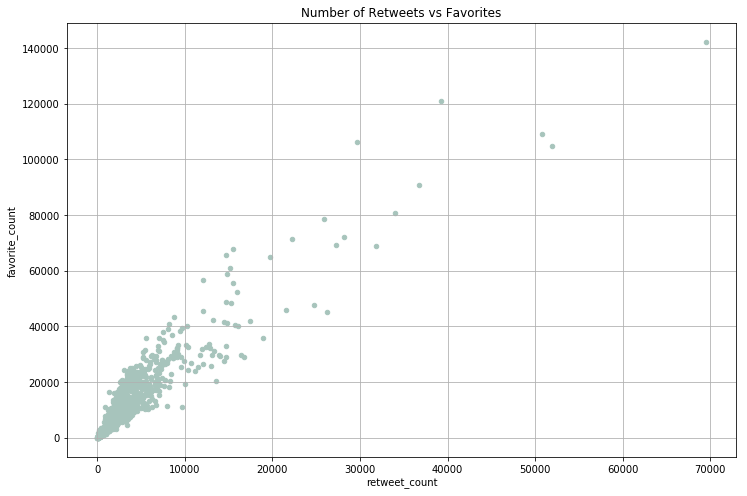

In [81]:
# Plot scatterplot of number of retweets vs favorites
a_x= "retweet_count"
a_y= "favorite_count"
a_kind= "scatter"
a_figsize= (12, 8)
a_title= "Number of Retweets vs Favorites"
a_grid= True
a_color= '#A7C4BC'

df.plot(x= a_x,
y= a_y,
kind= a_kind,
figsize= a_figsize,
title= a_title,
grid= a_grid,
color= a_color)

#### According to the graph above, there is a positive correlation between the two metrics.

### 2- How variables correlate to each others?

[Text(0.5,1,'Variables Correlation')]

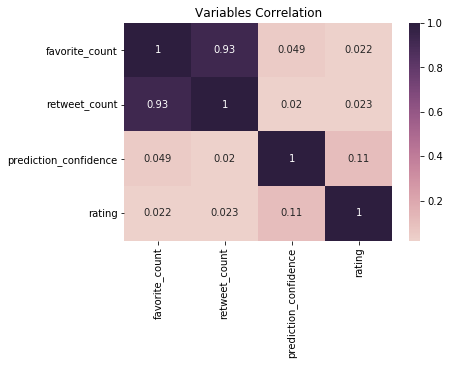

In [82]:
a_data= df[['favorite_count','retweet_count', 'prediction_confidence', 'rating']].corr()
a_figsize= (12, 8)
a_title= "Number of Retweets vs Favorites"

ax= sns.heatmap(a_data,
           cmap=sns.cubehelix_palette(as_cmap=True),
           annot=True)

ax.set(title= "Variables Correlation")

#### The evident correlation of 0.91 between favorite and retweets is the strongest.

### 3- Where do the majority of the numerators lie?

Text(0,0.5,'Frequency')

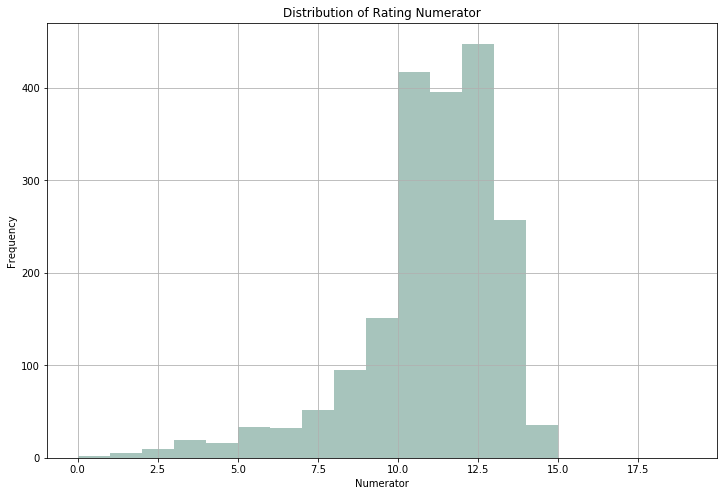

In [83]:
a_data= "rating_numerator"
a_kind= "hist"
a_figsize= (12, 8)
a_title= "Distribution of Rating Numerator"
a_grid= True
a_xlabel= 'Numerator'
a_ylabel= 'Frequency'
a_bins = range(0, 20)
a_color= '#A7C4BC'

df.hist(column= a_data,
figsize= a_figsize,
grid= a_grid,
bins = a_bins,
color= a_color)

plt.title(a_title)
plt.xlabel(a_xlabel)
plt.ylabel(a_ylabel)

#### As the plot shows, the majority of the numerators falls between 10 and 13.

### 4- What is the most common dog stage?

In [84]:
df['dog_stages'].unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

In [85]:
df.dog_stages.value_counts()

pupper            203
doggo              62
puppo              22
doggo, pupper       9
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stages, dtype: int64

Text(0,0.5,'count')

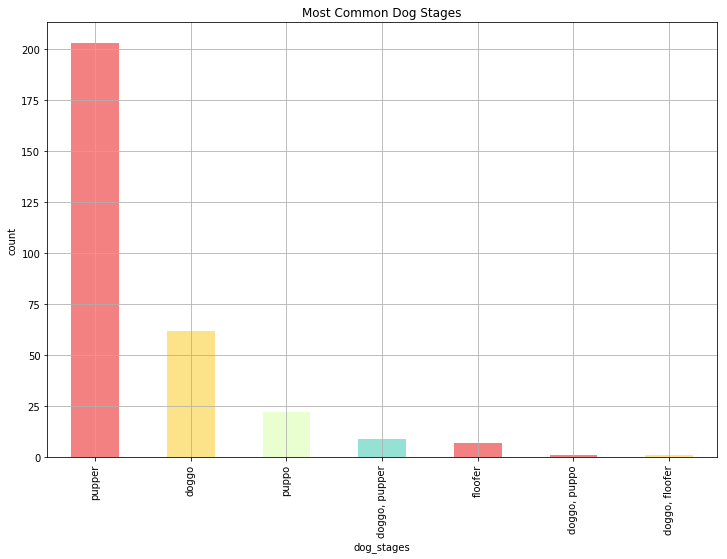

In [86]:
a_x= df['dog_stages'].value_counts()
a_kind= "bar"
a_figsize= (12, 8)
a_title= "Most Common Dog Stages"
a_xlabel= 'dog_stages'
a_ylabel= 'count'
a_grid= True
a_color= ["#F38181","#FCE38A","#EAFFD0","#95E1D3"]

a_x.plot(
       kind= a_kind,
       figsize= a_figsize,
       grid= a_grid,
       color= a_color)

plt.title(a_title)
plt.xlabel(a_xlabel)
plt.ylabel(a_ylabel)

#### Pupper is the most prevalent dog stage, as demonstrated above, appearing 206 times in the dataset. Doggo is the next, showing up 59 times.

### 5- Which dog stage received the highest retweets and favorites?

Text(0.5,1,'Number of Retweets vs Dog Stages')

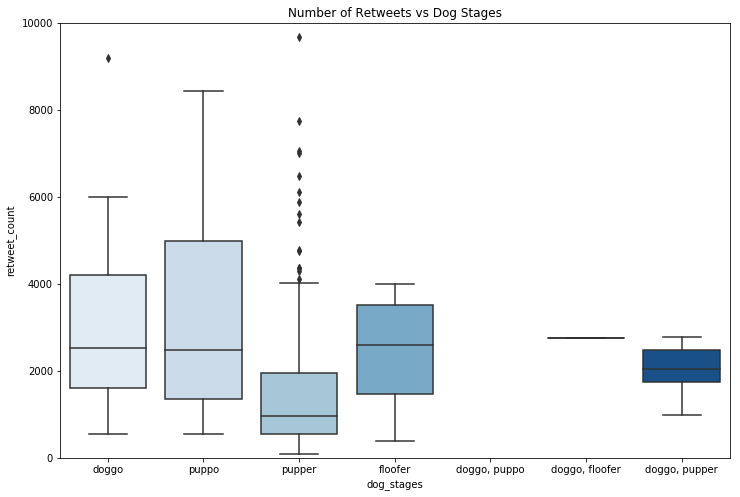

In [87]:
a_x= df['dog_stages']
a_y= df['retweet_count']
a_title= "Number of Retweets vs Dog Stages"
a_palette= "Blues"

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)
sns.boxplot(x= a_x, y= a_y, data= df, palette= a_palette)

plt.ylim(0,10000)
plt.title(a_title)

Text(0.5,1,'Number of Favorites vs Dog Stages')

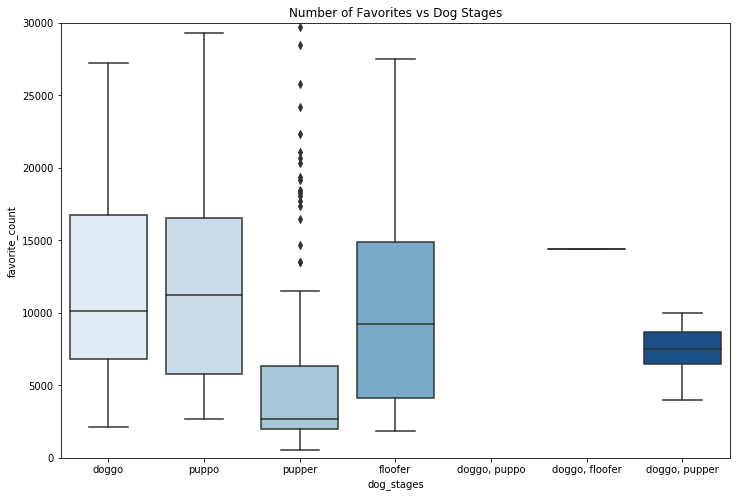

In [88]:
a_x= df['dog_stages']
a_y= df['favorite_count']
a_title= "Number of Favorites vs Dog Stages"
a_palette= "Blues"

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)
sns.boxplot(x= a_x, y= a_y, data= df, palette= a_palette)

plt.ylim(0,30000)
plt.title(a_title)

#### As was already mentioned, puppo and floofer are the dog stages that have received the most retweets. Additionally, the puppo got more favorite, followed by the doggo. While, pupper receives the least favorits and retweets overall.

### 6- What are the top 5 dog breeds prediction?

Text(0,0.5,'count')

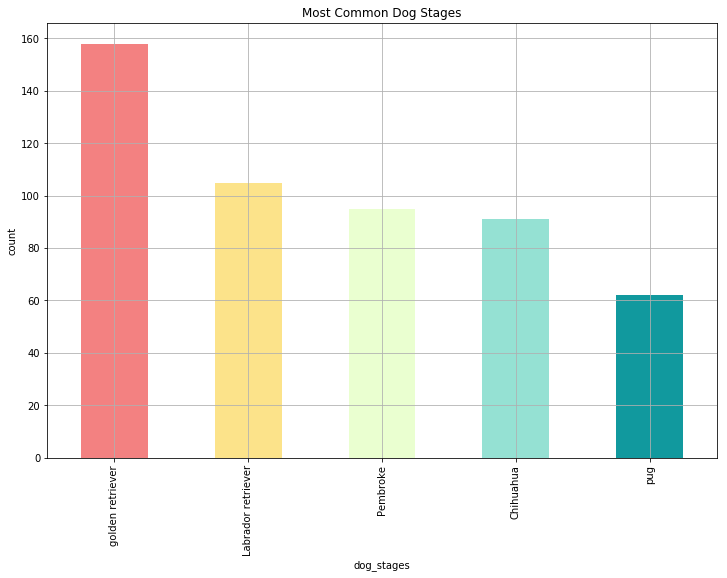

In [89]:


a_x= df['breed_prediction'].value_counts()[0:5].sort_values(ascending=False)
a_kind= "bar"
a_figsize= (12, 8)
a_title= "Most Common Dog Stages"
a_xlabel= 'dog_stages'
a_ylabel= 'count'
a_grid= True
a_color=['#F38181', '#FCE38A', '#EAFFD0', '#95E1D3', '#11999E']

a_x.plot(
       kind= a_kind,
       figsize= a_figsize,
       grid= a_grid,
       color= a_color)

plt.title(a_title)
plt.xlabel(a_xlabel)
plt.ylabel(a_ylabel)

#### The top five most common dog breeds are:
1. Golden Retriever
2. Labrador Retriever
3. Pembroke
4. Chihuahua
5. Pug.